In [1]:
#import libraries
import xgboost as xg
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold, KFold, GridSearchCV, cross_val_predict
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten, BatchNormalization, LeakyReLU
from sklearn.metrics import r2_score
import data_ML as ML
import pickle
from keras.models import load_model
from tqdm import tqdm
from sklearn.pipeline import Pipeline



np.set_printoptions(suppress=True)

In [2]:
df = ML.getdata(True)

def modifydata(df):
    data_calls = []
    data_puts = []
    df_puts = df[df.optionType == 0].drop(columns='optionType')
    df_calls = df[df.optionType == 1].drop(columns='optionType')
    df_american_calls = df_calls[df_calls.method == 1].drop(columns='method')
    df_american_puts = df_puts[df_puts.method == 1].drop(columns='method')
    df_american_calls = df_american_calls[df_american_calls.lastPrice > 10]
    df_american_puts = df_american_puts[df_american_puts.lastPrice > 10]
    y_calls = np.asarray(df_american_calls[['lastPrice']])
    y_puts = np.asarray(df_american_puts[['lastPrice']])
    df_american_calls = df_american_calls.drop(columns='lastPrice')
    df_american_puts = df_american_puts.drop(columns='lastPrice')

    for line in range(len(df_american_calls)):
        data_tmp = df_american_calls.iloc[line]
        data_calls.append(data_tmp)
    data_calls = np.asarray(data_calls)


    for line in range(len(df_american_puts)):
        data_tmp = df_american_puts.iloc[line]
        data_puts.append(data_tmp)
    data_puts = np.asarray(data_puts)

    print(df_american_calls)

    return data_calls, data_puts, y_calls, y_puts


In [3]:
X_calls, X_puts, y_calls, y_puts = modifydata(df)
X_train_calls, X_test_calls, y_train_calls, y_test_calls = train_test_split(X_calls, y_calls, test_size=0.25)
X_train_puts, X_test_puts, y_train_puts, y_test_puts = train_test_split(X_puts, y_puts, test_size=0.25)


        strike  maturity          S0     sigma   returns
14537     60.0  1.841096  174.260422  0.336283  0.264095
14540     60.0  1.841096  174.260422  0.336283  0.264095
14543     60.0  1.841096  174.260422  0.336283  0.264095
14546     60.0  1.841096  174.260422  0.336283  0.264095
14549     60.0  1.841096  174.260422  0.336283  0.264095
...        ...       ...         ...       ...       ...
243810    30.0  1.038356  251.490005  0.659344  0.500013
243811    10.0  2.035616  251.490005  0.659344  0.500013
243812    20.0  2.035616  251.490005  0.659344  0.500013
243815    65.0  1.063014  257.179993  0.660140  0.507208
243817    65.0  1.810959  257.179993  0.660140  0.507208

[6718 rows x 5 columns]


In [4]:
print(X_test_calls.shape)
print(X_train_calls.shape)
print(X_test_puts.shape)
print(X_train_puts.shape)

(1680, 5)
(5038, 5)
(2258, 5)
(6773, 5)


# Pipeline optimization

In [25]:
import seaborn as sns
palette = sns.color_palette('tab20',20)


def model(pipeline, parameters, X_train, y_train, X, y, figname):
    grid_obj = GridSearchCV(estimator = pipeline, param_grid = parameters, cv = 5, scoring = 'r2', verbose = 0, n_jobs = 1, refit = True)
    grid_obj.fit(X_train, y_train)

    print("Best Param:", grid_obj.best_params_)
    estimator = grid_obj.best_estimator_
    shuffle = KFold(n_splits = 5, shuffle = True, random_state = 0)
    cv_scores = cross_val_score(estimator, X, y.ravel(), cv=shuffle, scoring='r2')

    y_pred = cross_val_predict(estimator, X, y, cv = shuffle)
    plt.figure(figsize = (5,4))
    plt.scatter(y, y_pred, color = palette[0], s=10)
    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()
    plt.plot([xmin, xmax], [ymin, ymax], color = palette[1], lw = 2, alpha = 0.4)
    plt.xlabel("True Values")
    plt.ylabel("Predictions")
    plt.title('CV R-squared: {:.4f}\n'.format(float(cv_scores.mean())), size = 12)
    plt.savefig('./Presentation files/CV_XGBr_calls_plot.png')
    plt.show()

    return grid_obj.best_params_
    

Best Param: {'xgb__colsample_bytree': 1, 'xgb__gamma': 0.1, 'xgb__max_depth': 5, 'xgb__min_child_weight': 4, 'xgb__subsample': 0.8}


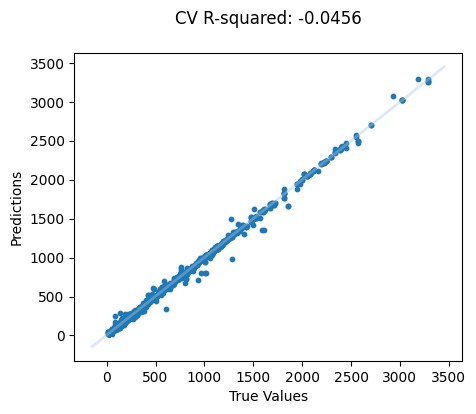

In [16]:
# XGBr Regressor for puts
%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')
pipe_xgb = Pipeline([('xgb', xg.XGBRegressor())])
param_xgb = {'xgb__max_depth':[3,4,5], 'xgb__min_child_weight':[4,5,6], 'xgb__gamma': [0.001, 0.01, 0.1], 'xgb__subsample':[0.6,0.7,0.8], 'xgb__colsample_bytree':[1]}
model(pipe_xgb, param_xgb, X_train_puts, y_train_puts, X_test_puts, y_test_puts, 'xgboost')

In [27]:
# XGBr Regressor for calls
%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')
pipe_xgb = Pipeline([('xgb', xg.XGBRegressor())])
param_xgb = {'xgb__max_depth':[3,4,5], 'xgb__min_child_weight':[3,4,5,6, 7, 8], 'xgb__gamma': [0.001,0.005, 0.01, 0.05, 0.1], 'xgb__subsample':[0.5,0.6,0.7,0.8,0.9], 'xgb__colsample_bytree':[1]}
model(pipe_xgb, param_xgb, X_train_calls, y_train_calls, X_test_calls, y_test_calls, 'xgboost')


Best Param: {'dt__max_depth': 24, 'dt__min_samples_leaf': 1}


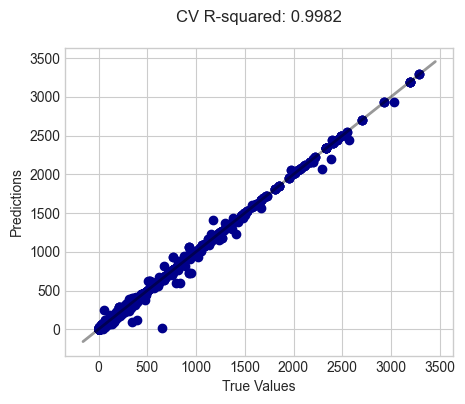

In [262]:
#DTR for puts
pipe_tree = Pipeline([('dt', DecisionTreeRegressor())])
param_tree = {'dt__max_depth': range(10,30), 'dt__min_samples_leaf': range(1,20)}
model(pipe_tree, param_tree, X_train_puts, y_train_puts, X_test_puts, y_test_puts, 'tree')

Best Param: {'dt__max_depth': 16, 'dt__min_samples_leaf': 1}


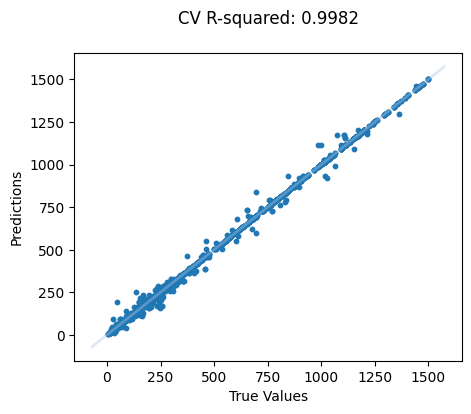

In [19]:
#DTR for calls
pipe_tree = Pipeline([('dt', DecisionTreeRegressor())])
param_tree = {'dt__max_depth': range(10,30), 'dt__min_samples_leaf': range(1,20)}
model(pipe_tree, param_tree, X_train_calls, y_train_calls, X_test_calls, y_test_calls, 'tree')

In [292]:
# XGBr for American call options
XGBr = xg.XGBRegressor(learning_rate=0.1, n_estimators=900)
cvs_XGBr = cross_val_score(XGBr, X_train_calls, y_train_calls, scoring='neg_root_mean_squared_error', cv=KFold(n_splits=10))
XGBr_score = cvs_XGBr.mean()
print(XGBr_score)


-5.730392124898603


In [21]:
XGBr = xg.XGBRegressor(learning_rate=0.1, colsample_bytree=1, gamma=0.1, max_depth=5, min_child_weight=3, subsample=0.9, n_estimators=900)
XGBr.fit(X_train_calls, y_train_calls)
XGBr_pred = XGBr.predict(X_test_calls)
XGBr_rmse = np.sqrt(mean_squared_error(y_test_calls, XGBr_pred))
XGBr_rmse
# Best Param: {'xgb__colsample_bytree': 1, 'xgb__gamma': 0.1, 'xgb__max_depth': 5, 'xgb__min_child_weight': 3, 'xgb__subsample': 0.9}

9.923558884894788

In [24]:
# Save the trained model to a file
filename = 'XGBr_model_calls.sav'
pickle.dump(XGBr, open(filename, 'wb'))

In [8]:
y_pred = pd.DataFrame(XGBr_pred, columns=['prediction'])
final_test = pd.DataFrame(y_test_calls, columns=['real'])

final_df = pd.concat((final_test, y_pred), axis=1)
final_df

,real,prediction
0,80.90,80.115250
1,78.11,78.650833
2,922.00,924.189697
3,552.01,552.347168
4,685.23,682.741699
...,...,...
1675,40.17,41.357128
1676,148.72,149.286377
1677,62.42,60.560356
1678,198.29,195.998322


In [294]:
# XGBr for American puts options
XGBr = xg.XGBRegressor(learning_rate=0.05, colsample_bytree=1, gamma=0.001, max_depth=5, min_child_weight=4, subsample=0.07, n_estimators=900)
cvs_XGBr = cross_val_score(XGBr, X_train_puts, y_train_puts, scoring='neg_root_mean_squared_error', cv=KFold(n_splits=10))
XGBr_score = cvs_XGBr.mean()
print(XGBr_score)


-16.43855461271371


In [22]:
XGBr = xg.XGBRegressor(learning_rate=0.1, colsample_bytree=1, gamma=0.1, max_depth=5, min_child_weight=4, subsample=0.8, n_estimators=900)
XGBr.fit(X_train_puts, y_train_puts)
XGBr_pred = XGBr.predict(X_test_puts)
XGBr_rmse = np.sqrt(mean_squared_error(y_test_puts, XGBr_pred))
XGBr_rmse
# Best Param: {'xgb__colsample_bytree': 1, 'xgb__gamma': 0.1, 'xgb__max_depth': 5, 'xgb__min_child_weight': 4, 'xgb__subsample': 0.8}

8.564699083372458

In [23]:
# Save the trained model to a file
filename = 'XGBr_model_puts.sav'
pickle.dump(XGBr, open(filename, 'wb'))

In [24]:
y_pred = pd.DataFrame(XGBr_pred, columns=['prediction'])
final_test = pd.DataFrame(y_test_puts, columns=['real'])

final_df = pd.concat((final_test, y_pred), axis=1)
final_df

,real,prediction
0,198.00,195.753677
1,11.65,12.288597
2,325.35,327.793060
3,61.25,58.466328
4,349.53,350.821777
...,...,...
6060,69.80,68.956879
6061,154.26,150.325150
6062,10.70,11.020219
6063,58.73,59.929966


In [14]:
DTR_calls = DecisionTreeRegressor(max_depth=27, min_samples_leaf=1)
# cvs_DTR = cross_val_score(DTR, df_train, y_train, scoring='neg_root_mean_squared_error', cv=5)
# DTR_score = cvs_DTR.mean()
# print(DTR_score)

DTR_calls.fit(X_train_calls, y_train_calls)
DTR1_pred = DTR_calls.predict(X_test_calls)
DTR1_rmse = np.sqrt(mean_squared_error(y_test_calls, DTR1_pred))
DTR1_rmse
# Best Param: {'dt__max_depth': 27, 'dt__min_samples_leaf': 1}

10.239655258915144

In [287]:
y_pred = pd.DataFrame(DTR1_pred, columns=['prediction'])
final_test = pd.DataFrame(y_test_calls, columns=['real'])

final_df = pd.concat((final_test, y_pred), axis=1)
final_df

,real,prediction
0,18.25,18.25
1,74.20,74.20
2,125.06,125.06
3,10.05,10.05
4,10.05,10.05
...,...,...
9058,317.00,317.00
9059,182.60,182.60
9060,21.38,21.38
9061,460.00,460.00


In [52]:
# Save the trained model to a file
filename = 'DTR_model_calls.sav'
pickle.dump(DTR_calls, open(filename, 'wb'))

In [281]:
DTR_puts = DecisionTreeRegressor(max_depth=24, min_samples_leaf=1)
# cvs_DTR = cross_val_score(DTR, df_train, y_train, scoring='neg_root_mean_squared_error', cv=5)
# DTR_score = cvs_DTR.mean()
# print(DTR_score)

DTR_puts.fit(X_train_puts, y_train_puts)
DTR1_pred = DTR_puts.predict(X_test_puts)
DTR1_rmse = np.sqrt(mean_squared_error(y_test_puts, DTR1_pred))
DTR1_rmse
# Best Param: {'dt__max_depth': 24, 'dt__min_samples_leaf': 1}

6.488836372500458

In [47]:
y_pred = pd.DataFrame(DTR1_pred, columns=['prediction'])
final_test = pd.DataFrame(y_test_puts, columns=['real'])

final_df = pd.concat((final_test, y_pred), axis=1)
final_df

,real,prediction
0,283.68,283.68
1,125.32,120.67
2,6.25,6.25
3,43.00,43.00
4,482.70,482.70
...,...,...
6060,71.10,71.10
6061,22.30,22.30
6062,15.90,15.90
6063,13.05,13.05


In [48]:
# Save the trained model to a file
filename = 'DTR_model_puts.sav'
pickle.dump(DTR_puts, open(filename, 'wb'))

### EU options

In [25]:
df = ML.getdata(True)

def modifydata(df):
    data_calls = []
    data_puts = []
    df_puts = df[df.optionType == 0].drop(columns='optionType')
    df_calls = df[df.optionType == 1].drop(columns='optionType')
    df_eu_calls = df_calls[df_calls.method == 0].drop(columns='method')
    df_eu_puts = df_puts[df_puts.method == 0].drop(columns='method')
    df_eu_calls = df_eu_calls.drop(columns='index')
    df_eu_calls = df_eu_calls[df_eu_calls.lastPrice > 5]
    df_eu_puts = df_eu_puts[df_eu_puts.lastPrice > 5]
    df_eu_puts = df_eu_puts.drop(columns='index')
    y_calls = np.asarray(df_eu_calls[['lastPrice']])
    y_puts = np.asarray(df_eu_puts[['lastPrice']])
    df_eu_calls = df_eu_calls.drop(columns='lastPrice')
    df_eu_puts = df_eu_puts.drop(columns='lastPrice')

    for line in range(len(df_eu_calls)):
        data_tmp = df_eu_calls.iloc[line]
        data_calls.append(data_tmp)
    data_calls = np.asarray(data_calls)


    for line in range(len(df_eu_puts)):
        data_tmp = df_eu_puts.iloc[line]
        data_puts.append(data_tmp)
    data_puts = np.asarray(data_puts)

    return data_calls, data_puts, y_calls, y_puts

In [26]:
X_calls, X_puts, y_calls, y_puts = modifydata(df)
X_train_calls, X_test_calls, y_train_calls, y_test_calls = train_test_split(X_calls, y_calls, test_size=0.25)
X_train_puts, X_test_puts, y_train_puts, y_test_puts = train_test_split(X_puts, y_puts, test_size=0.25)

In [27]:
print(X_test_calls.shape)
print(X_train_calls.shape)
print(X_test_puts.shape)
print(X_train_puts.shape)

(14403, 6)
(43209, 6)
(12856, 6)
(38565, 6)


In [202]:
# XGBr for European call options
XGBr_eu_calls = xg.XGBRegressor(learning_rate=0.1, colsample_bytree= 1, gamma= 0.001, max_depth= 5, min_child_weight= 4, subsample= 0.7, n_estimators=900)
cvs_XGBr = cross_val_score(XGBr, X_train_calls, y_train_calls, scoring='neg_root_mean_squared_error', cv=KFold(n_splits=10))
XGBr_score = cvs_XGBr.mean()
print(XGBr_score)

-43.93321704710112


In [206]:
XGBr_eu_calls = xg.XGBRegressor(learning_rate=0.1, colsample_bytree= 1, gamma= 0.001, max_depth= 5, min_child_weight= 4, subsample= 0.7, n_estimators=900)
XGBr_eu_calls.fit(X_train_calls, y_train_calls)
XGBr_pred = XGBr_eu_calls.predict(X_test_calls)
XGBr_rmse = np.sqrt(mean_squared_error(y_test_calls, XGBr_pred))
XGBr_rmse

74.7224953351218

In [168]:
# XGBr for European call options
XGBr_eu_puts = xg.XGBRegressor(learning_rate=0.1, n_estimators=900)
cvs_XGBr = cross_val_score(XGBr, X_train_puts, y_train_puts, scoring='neg_root_mean_squared_error', cv=KFold(n_splits=10))
XGBr_score = cvs_XGBr.mean()
print(XGBr_score)

-41.43701782995156


In [201]:

XGBr_eu_puts = xg.XGBRegressor(learning_rate=0.1, colsample_bytree= 1, gamma= 0.001, max_depth= 5, min_child_weight= 4, subsample= 0.7, n_estimators=800)
XGBr_eu_puts.fit(X_train_puts, y_train_puts)
XGBr_pred = XGBr_eu_puts.predict(X_test_puts)
XGBr_rmse = np.sqrt(mean_squared_error(y_test_puts, XGBr_pred))
XGBr_rmse



27.985915046769126

In [212]:
# Save the trained model to a file
filename = 'XGBr_eu_puts.sav'
pickle.dump(XGBr_eu_puts, open(filename, 'wb'))
filename = 'XGBr_eu_calls.sav'
pickle.dump(XGBr_eu_calls, open(filename, 'wb'))

In [210]:
DTR_calls = DecisionTreeRegressor(max_depth=24, min_samples_leaf=1)
# cvs_DTR = cross_val_score(DTR, df_train, y_train, scoring='neg_root_mean_squared_error', cv=5)
# DTR_score = cvs_DTR.mean()
# print(DTR_score)

DTR_calls.fit(X_train_calls, y_train_calls)
DTR1_pred = DTR_calls.predict(X_test_calls)
DTR1_rmse = np.sqrt(mean_squared_error(y_test_calls, DTR1_pred))
DTR1_rmse

99.6828650937288

In [177]:
def model(pipeline, parameters, X_train, y_train, X, y, figname):
    grid_obj = GridSearchCV(estimator = pipeline, param_grid = parameters, cv = 5, scoring = 'r2', verbose = 0, n_jobs = 1, refit = True)
    grid_obj.fit(X_train, y_train)

    print("Best Param:", grid_obj.best_params_)
    estimator = grid_obj.best_estimator_
    shuffle = KFold(n_splits = 5, shuffle = True, random_state = 0)
    cv_scores = cross_val_score(estimator, X, y.ravel(), cv=shuffle, scoring='r2')

    y_pred = cross_val_predict(estimator, X, y, cv = shuffle)
    plt.figure(figsize = (5,4))
    plt.scatter(y, y_pred, color = "darkblue")
    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()
    plt.plot([xmin, xmax], [ymin, ymax], "black", lw = 2, alpha = 0.4)
    plt.xlabel("True Values")
    plt.ylabel("Predictions")
    plt.title('CV R-squared: {:.4f}\n'.format(float(cv_scores.mean())), size = 12)
    plt.show()








Best Param: {'dt__max_depth': 21, 'dt__min_samples_leaf': 1}


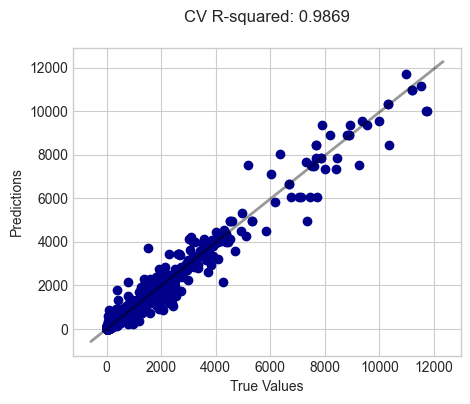

In [178]:
#DTR for calls
pipe_tree = Pipeline([('dt', DecisionTreeRegressor())])
param_tree = {'dt__max_depth': range(10,30), 'dt__min_samples_leaf': range(1,20)}
model(pipe_tree, param_tree, X_train_calls, y_train_calls, X_test_calls, y_test_calls, 'tree')

In [184]:
DTR_puts = DecisionTreeRegressor(max_depth=22, min_samples_leaf=1)
# cvs_DTR = cross_val_score(DTR, df_train, y_train, scoring='neg_root_mean_squared_error', cv=5)
# DTR_score = cvs_DTR.mean()
# print(DTR_score)

DTR_puts.fit(X_train_puts, y_train_puts)
DTR1_pred = DTR_puts.predict(X_test_puts)
DTR1_rmse = np.sqrt(mean_squared_error(y_test_puts, DTR1_pred))
DTR1_rmse

19.33815293308031

Best Param: {'dt__max_depth': 22, 'dt__min_samples_leaf': 1}


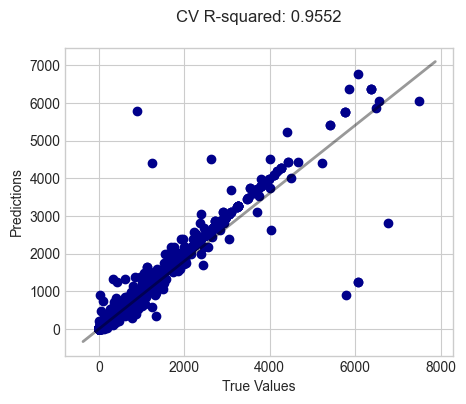

In [185]:
#DTR for puts
pipe_tree = Pipeline([('dt', DecisionTreeRegressor())])
param_tree = {'dt__max_depth': range(10,30), 'dt__min_samples_leaf': range(1,20)}
model(pipe_tree, param_tree, X_train_puts, y_train_puts, X_test_puts, y_test_puts, 'tree')

Best Param: {'xgb__colsample_bytree': 1, 'xgb__gamma': 0.001, 'xgb__max_depth': 5, 'xgb__min_child_weight': 6, 'xgb__subsample': 0.8}


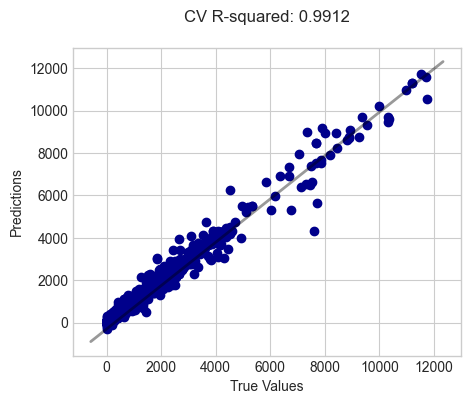

In [166]:
# XGBr Regressor for calls
pipe_xgb = Pipeline([('xgb', xg.XGBRegressor())])
param_xgb = {'xgb__max_depth':[3,4,5], 'xgb__min_child_weight':[4,5,6], 'xgb__gamma': [0.001, 0.01, 0.1], 'xgb__subsample':[0.6,0.7,0.8], 'xgb__colsample_bytree':[1]}
model(pipe_xgb, param_xgb, X_train_calls, y_train_calls, X_test_calls, y_test_calls, 'xgboost')

Best Param: {'xgb__colsample_bytree': 1, 'xgb__gamma': 0.001, 'xgb__max_depth': 5, 'xgb__min_child_weight': 4, 'xgb__subsample': 0.7}


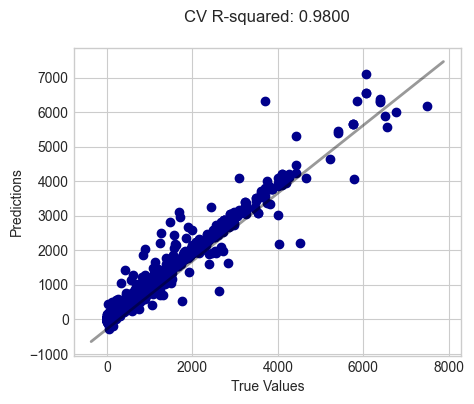

In [195]:
# XGBr Regressor for puts
pipe_xgb = Pipeline([('xgb', xg.XGBRegressor())])
param_xgb = {'xgb__max_depth':[3,4,5], 'xgb__min_child_weight':[4,5,6], 'xgb__gamma': [0.001, 0.01, 0.1], 'xgb__subsample':[0.6,0.7,0.8], 'xgb__colsample_bytree':[1]}
model(pipe_xgb, param_xgb, X_train_puts, y_train_puts, X_test_puts, y_test_puts, 'xgboost')

In [211]:
# Save the trained model to a file
filename = 'DTR_eu_puts.sav'
pickle.dump(DTR_puts, open(filename, 'wb'))
# Save the trained model to a file
filename = 'DTR_eu_calls.sav'
pickle.dump(DTR_calls, open(filename, 'wb'))